In [1]:
from __future__ import print_function

import os
import glob
import rosbag
import pandas as pd
import numpy as np
import cv2
import time 

import ipywidgets as widgets
import seaborn as sns
import matplotlib.pyplot as plt

from os import path
from utils.visualisation import *
from utils.postprocessing.utils import csvs2dfs
from functools import reduce
from utils.postprocessing.config import Config
from ipywidgets import interact, interactive, fixed, interact_manual
from utils.visualisation import *
from utils.postprocessing.utils import *
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib import gridspec

/home/francesco/.local/lib/python3.6/site-packages/skimage/novice/__init__.py:103: UserWarning: The `skimage.novice` module was deprecated in version 0.14. It will be removed in 0.16.
  warnings.warn("The `skimage.novice` module was deprecated in version 0.14. "


In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [3]:
%%html
<style>

.div.output_scroll {
    height : auto;
}
</style>

# Visualize the simulation
Visualize the robot's simulation on a specific map is tremendously to understand if everything went perfect. Also, we can have an idea about the generated dataset.

In [4]:
class DebugPipeline():
    def __init__(self, hm):
        self.hm = hm
        self.patch_size = 100 // 2
    
    @property
    def hm_ax(self):
        fig = plt.figure()
        ax = sns.heatmap(hm)
        return ax 
    
    def show_map(self, hm):
        self.hm_ax
        plt.show()
            
    def show_traces(self, dfs, ax=None):
        if ax is None: ax = self.hm_ax
        
        start_marker = mlines.Line2D([], [],marker='o', color='g', ls='', label='start')
        finish_marker = mlines.Line2D([], [],marker='o', color='r', ls='', label='finish')

        for df in dfs:
            initial_pos = df.hm_x.iloc[0], df.hm_y.iloc[0]
            last_position = df.hm_x.iloc[-1], df.hm_y.iloc[-1]
            ax.plot(*initial_pos, marker='o', color='g', ls='', label='start')
            ax.plot(*last_position, marker='o', color='r', ls='', label='finish')
            ax.plot(df.hm_x,  df.hm_y, '--', linewidth=2, color='white', label='path')
            
        ax.legend(handles=[start_marker, finish_marker])

        return ax
    
    def show_patches(self, df, center=False, n_samples=4, scale=1, random_state=0):
        sample = df.sample(n_samples, random_state=random_state)
        fig, ax = plt.subplots(nrows=n_samples // 2, ncols=n_samples // 2)
        fig.suptitle('patches center={}'.format(center))
        for row in ax:
            for idx, (col, (i, row)) in enumerate(zip(row, sample.iterrows())):
                x, y = row["hm_x"],row["hm_y"]
                patch, _ = hmpatch(self.hm, x, y,np.rad2deg(row['pose__pose_position_z']),  self.patch_size,scale=1)
                patch = patch.astype(np.float32)
                if center: patch = patch - patch[patch.shape[0] // 2, patch.shape[1] // 2]                    
                col.plot(self.patch_size // 2, self.patch_size // 2, marker='o', color='r', ls='', linewidth=10, label='finish')                
                sns.heatmap(patch, ax=col)
        
        plt.show()
        
    def show_patch_on_the_map(self, sample):
        fig = plt.figure(figsize=(6, 12))


        x, y, ang, ad = sample["hm_x"], \
            sample["hm_y"], \
            sample['pose__pose_position_z'], \
            sample["advancement"]
        
        ax1 = plt.subplot(2, 1, 1)
        ax2 = plt.subplot(2, 1, 2)

        ax1.set_title("advancement: {:.4f}, x={:.0f}, y={:.0f}".format(ad, 
                                                                      x,
                                                                      y))
        sns.heatmap(self.hm, ax=ax1)
        rect = patches.Rectangle((x -  self.patch_size // 2,y -  self.patch_size // 2), self.patch_size, 
                                 self.patch_size, linewidth=1, edgecolor='r', facecolor='none')
        ax1.add_patch(rect)

        patch, _ = hmpatch(self.hm, x, y,np.rad2deg(ang),  self.patch_size ,scale=1)
        sns.heatmap(patch, ax=ax2)

        
    def show_patches_on_the_map(self, df):
        n_show = 4

        fig = plt.figure(figsize=(12,12))
        
        size = (2 + n_show//2 , 2 + n_show//2)
        gridspec.GridSpec(*size)
        
        ax_hm = plt.subplot2grid((size), (0,0), colspan=2, rowspan=2)
        
        sns.heatmap(self.hm / 255, ax=ax_hm)

        self.show_traces([df], ax=ax_hm)
        
        subset = df.loc[list(range(0, len(df), len(df) // n_show)), :]
        print(list(range(0, len(df), len(df) // n_show)))
        hm_patches = []
        for i, row in subset.iterrows():
            x, y, ang, ad = row["hm_x"], \
            row["hm_y"], \
            row["pose__pose_position_z"], \
            row["advancement"]
            rect = patches.Rectangle((x -  self.patch_size // 2,y -  self.patch_size // 2), self.patch_size, 
                                 self.patch_size, linewidth=1, edgecolor='r', facecolor='none')
            ax_hm.add_patch(rect)
        
            patch, _ = hmpatch(self.hm, x, y,np.rad2deg(ang),  self.patch_size ,scale=1)
            hm_patches.append(patch)
        
        for i in range(n_show//2):
            for j in range(n_show//2):
                ax_patch = plt.subplot2grid((size), (2 + i, j), colspan=1, rowspan=1)
                sns.heatmap(hm_patches[i + j], ax=ax_patch)
            
    def show_traversability_in_time(self, df, dt=100):
        fig = plt.figure()
        plt.title('advancement')
        plt.plot( df.index, df['advancement'])
        plt.show()
    
    
    def plot_rotation(self, df):
        fig = plt.figure()
        plt.title('rotation')
        ax1 = plt.subplot(3, 1, 1)
        ax2 = plt.subplot(3, 1, 2)
        ax3 = plt.subplot(3, 1, 3)
        ax1.set_title('yaw')
        df['pose__pose_e_orientation_x'].plot(ax=ax1)
        ax3.set_title('pitch')
        df['pose__pose_e_orientation_y'].plot(ax=ax2)
        ax3.set_title('roll')
        df['pose__pose_e_orientation_z'].plot(ax=ax3)
        plt.legend()
        
    def plot_position(self, df):
        fig = plt.figure()
        plt.title('position')
        df['pose__pose_position_x'].plot(label='x')
        df['pose__pose_position_y'].plot(label='y')
        plt.legend()
        
        
    def __call__(self, df, dt=100):
        self.show_patches_on_the_map(df)
        self.plot_rotation(df)
        self.plot_position(df)
        self.show_traversability_in_time(df)
        
        

In [30]:
def folder2maps(folder):
    maps = glob.glob('/home/francesco/Documents/Master-Thesis/core/maps/{}/*.png'.format(folder))
    return maps, list(map(lambda x : path.splitext(path.basename(x))[0], maps))


def maps2dfs(map_name):
    hm = cv2.imread('/home/francesco/Documents/Master-Thesis/core/maps/{}/{}.png'.format(folder, map_name))
    hm = cv2.cvtColor(hm, cv2.COLOR_BGR2GRAY)
    
    csvs_paths = glob.glob('/home/francesco/Desktop/carino/vaevictis/data/train_no_tail/{}/csvs/{}/*.csv'.format(folder, map_name))
    dfs = csvs2dfs(csvs_paths)
    print(len(dfs))
    return csvs_paths, dfs, hm


w1 = interactive(folder2maps, folder=['train', 'val'])
display(w1)


interactive(children=(Dropdown(description='folder', options=('train', 'val'), value='train'), Output()), _dom…

In [40]:
folder = w1.kwargs['folder']

map_pathes, map_names = w1.result
print(folder)
w2 = interactive(maps2dfs, map_name=map_names)

display(w2)

train


interactive(children=(Dropdown(description='map_name', options=('slope_rocks3', 'holes2', 'bumps2', 'rails2', …

## Visualize the robot's trace
Below we plotted all the robot's positions for the given map

## Plotting statistics

In [63]:
csvs_paths, dfs, hm = w2.result

In [39]:
csvs_paths = glob.glob('/home/francesco/Desktop/carino/vaevictis/data_old/train/csvs/flat/*.csv')
dfs = csvs2dfs(csvs_paths)
print(len(dfs))


47


In [19]:
dfs_clean = []

offset = 25

for df in dfs:
    index = df[(df['hm_y'] > (hm.shape[0] - 25)) | (df['hm_y'] <  25) 
               | (df['hm_x'] > (hm.shape[1] - 25)) | (df['hm_x'] <  25)
              ].index

    if len(index) > 0:
        idx = index[0]
        df = df.loc[0:idx]
    if len(df) > 0:    
        dfs_clean.append(df)

In [20]:
len(dfs_clean)

95

In [11]:
hm.shape

(513, 513)

In [12]:
df = dfs[1]

tmp = df[df['hm_y'] < 15].index[0]
tmp = df.loc[0:62]

<IPython.core.display.Javascript object>


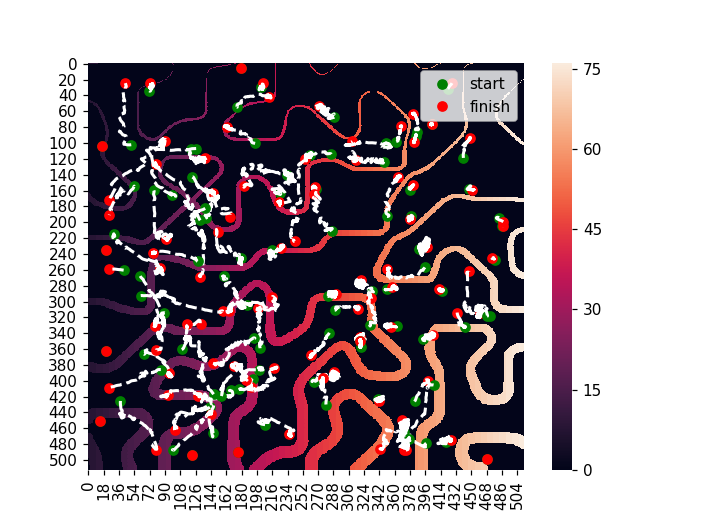

In [36]:
deb_pip.show_traces(dfs_clean)

In [64]:
df_total = pd.concat(filter(lambda x: len(x) > 0, dfs))
df_total = df_total.dropna()
df_total = df_total.reset_index() # we need to reset the index otherwise the plots are based on the old overlapping indexes

### Advancement
Below we show a box plot of the advancement

<IPython.core.display.Javascript object>


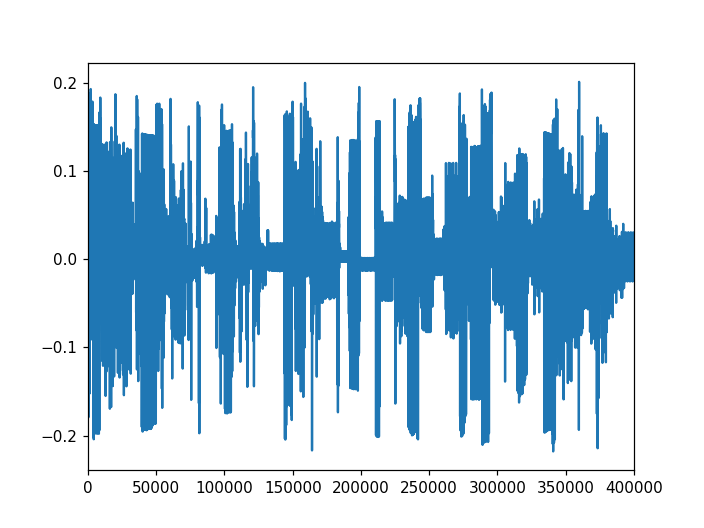

In [65]:
fig = plt.figure()
df_total['advancement'].plot.line()

/home/francesco/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


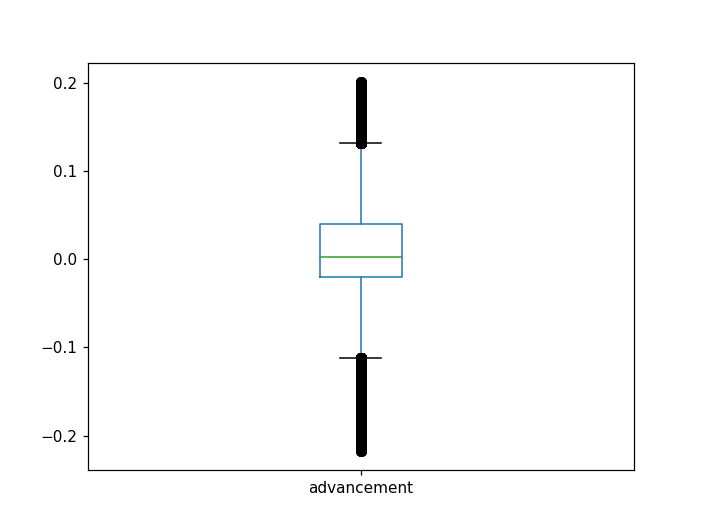

0.007086126350214562

In [66]:
fig = plt.figure()
df_total['advancement'].plot.box()
df_total['advancement'].mean()

In [23]:
df_total['advancement'].min()

-0.2450483867280129

# Debug

In [48]:
%%html
<style>

.div.output_scroll {
    height : auto !important;
}
</style>

/home/francesco/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


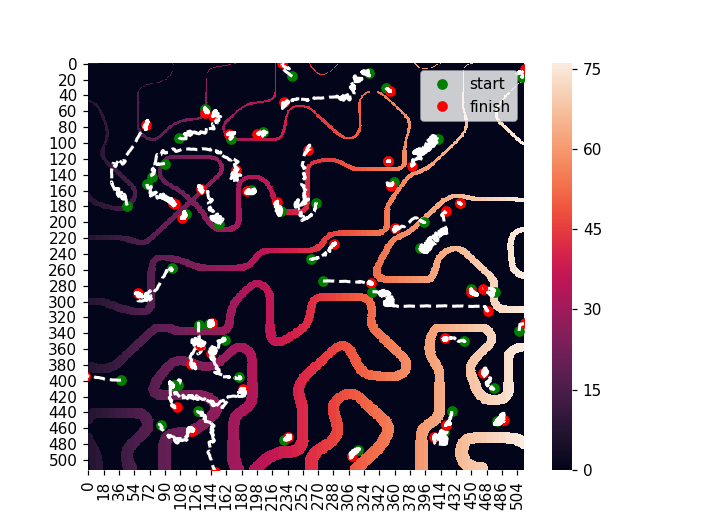

In [67]:
deb_pip = DebugPipeline(hm)
deb_pip.show_traces(dfs)

In [51]:
%%html
<style>

div.output_scroll {
    height : auto !important;
}
</style>

In [68]:
def csv_path2debug(csv_path):
    idx = csvs_paths.index(csv_path)
    deb_pip(dfs[idx])
    

interact(csv_path2debug, csv_path=csvs_paths);

interactive(children=(Dropdown(description='csv_path', options=('/home/francesco/Desktop/carino/vaevictis/data…

# Debug our coordinate function

This is krock on the simulator

![alt]("./images/bars1_krock.jpg")


In [ ]:
def to_hm_coordinates(row, hm, res, tr=[0, 0]):
    x, y = row['pose__pose_position_x'], row['pose__pose_position_y']
    x_max, y_max = hm.shape[0] * res, hm.shape[1] * res
    x_min, y_min = tr

    xs = x + x_min
    ys = -y + y_min

    return pd.Series([xs / res, ys / res])